# This is a library to find the best performing configuration from a set of dimensions (i.e. schemas, partition, storage) which can be specified inside the <b>settings.yaml</b> file in the resource

In [ ]:
%pip install PAPyA==0.1.0

### Load configuration file and log files location for the experiment

In [3]:
config = "settings.yaml" # config file location
logs = "log" # logs file location

#### Configuration file <br>
the configuration is a yaml file which has two main parts, the dimensions and the number of query experiments. You can add more dimensions here or change these existing dimensions to anything you need

```yaml
dimensions:
    schemas: ["st", "vt", "pt", "extvt", "wpt"]
    partition: ["horizontal", "predicate", "subject"]
    storage: ["csv", "avro", "parquet", "orc"]

query: 11
```

#### Log file structure <br>
the structure of the log files must follow the order of dimensions in the configuration file (i.e. {schemas}.{partition}.{storage}.txt) and the subfolders should be the ranking sets of the experiments (i.e. dataset sizes)

```
UI Module
└───log
    │
    |───100M
    |    │   st.horizontal.csv.txt
    |    │   st.horizontal.avro.txt
    |    │   ...
    │
    └───250M
        |   st.horizontal.csv.txt
        │   st.horizontal.avro.txt
        │   ...
```

### Single Dimensional Ranking

<b>SDRank</b> is a class module from PAPyA library to calculate ranking score _R_ for each dimension independently that operates over a log-based structure that user specified on the configuration file.<br> 
The value of _R_ represents the performance of a particular configuration (higher value means better performing configuration). We used Ranking Function _R_ below to calculate the rank scores:

$$R =\sum \limits _{r=1} ^{d} \frac{O_{dim} * (d-r)}{|Q| * (d-1)}, 0<R<=1$$

$d$         : total number of parameters (options) in a particular dimension<br>
$O_{dim}$   : number of occurences of the dimension placed at rank $r$ (Rank 1, Rank 2, Rank 3, ...)<br>
$|Q|$       : total number of queries

In [12]:
# this class takes single dimension and dataset sizes as parameters that user specified inside their log files
from PAPyA.Rank import SDRank

schemaSDRank = SDRank(config, logs, '100M', 'schemas')
partitionSDRank = SDRank(config, logs, '100M', 'partition')
storageSDRank = SDRank(config, logs, '100M', 'storage')

<b>calculateRank</b> is the function that automates calculating the rank scores of a single dimension using the Ranking Function above.<br>
The output of this method is a table of configurations which is sorted based on the best performing configuration according to their Ranking Score along with number of occurences of the dimension being placed at the rank _r_ (1st, 2nd, 3rd, ...)

In [5]:
# this is the top 5 rank scores of configurations in schema dimension sorted from best to worst
schemaSDRank.calculateRank().head()

,Rank 1,Rank 2,Rank 3,Rank 4,Rank 5,Result
vt.predicate.avro,6.0,2.0,1.0,2.0,0.0,0.772727
vt.predicate.csv,6.0,2.0,1.0,2.0,0.0,0.772727
vt.predicate.parquet,6.0,2.0,1.0,2.0,0.0,0.772727
extvt.predicate.csv,3.0,6.0,1.0,0.0,1.0,0.727273
vt.predicate.orc,3.0,5.0,1.0,2.0,0.0,0.704545


In [6]:
# this is the top 5 rank scores of configurations in storage dimension sorted from best to worst
storageSDRank.calculateRank().head()

,Rank 1,Rank 2,Rank 3,Rank 4,Result
st.predicate.orc,10.0,1.0,0.0,0.0,0.969697
st.subject.orc,10.0,1.0,0.0,0.0,0.969697
st.horizontal.orc,8.0,3.0,0.0,0.0,0.909091
vt.subject.parquet,5.0,5.0,1.0,0.0,0.787879
extvt.subject.parquet,6.0,3.0,1.0,1.0,0.757576


In [7]:
# this is the top 5 rank scores of configurations in partition dimension sorted from best to worst
partitionSDRank.calculateRank().head()

,Rank 1,Rank 2,Rank 3,Result
st.subject.parquet,10.0,1.0,0.0,0.954545
st.subject.orc,10.0,1.0,0.0,0.954545
vt.subject.parquet,9.0,1.0,1.0,0.863636
st.subject.avro,8.0,3.0,0.0,0.863636
vt.subject.avro,8.0,2.0,1.0,0.818182


Ranking over one dimension is insufficient when it counts multiple dimensions. The presence of trade-offs reduces the accuracy of single dimension ranking functions which could be seen in the radar plot below. <br>
<b>plotRadar</b> is a method to show the presence of trade-offs by using the single dimension ranking criterion that reduces the accuracy of the other dimensions

_schemaSDRank.plotRadar()_ shows a figure of the top configuration (vt.predicate.avro) of ranking by schema is optimized towards schema dimension only, ignoring the other two dimension.<br>
The same can be said for ranking with the other dimensions (storage and partition)

In [8]:
schemaSDRank.plotRadar()

In [9]:
storageSDRank.plotRadar()

In [10]:
partitionSDRank.plotRadar()

In addition to radar plot, PAPyA also provides visualization that shows the performance of a single dimension parameters that user can choose in terms of their rank scores<br>
This <b>plot</b> method takes a single argument which is the view projection option that user can specify

<AxesSubplot:title={'center':'avro'}>

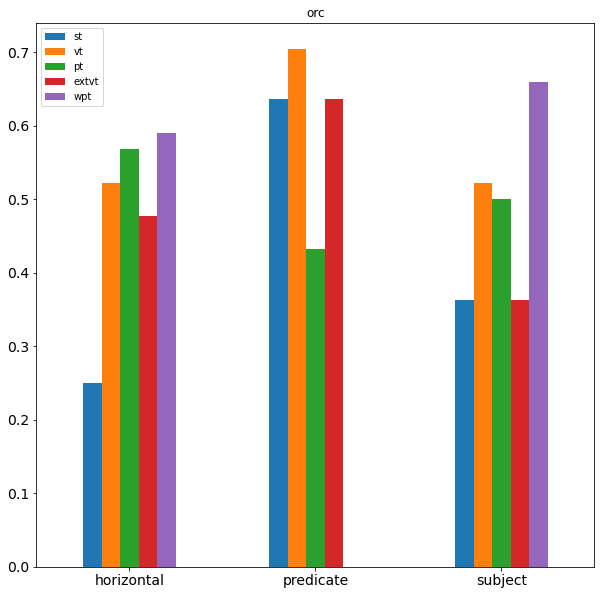

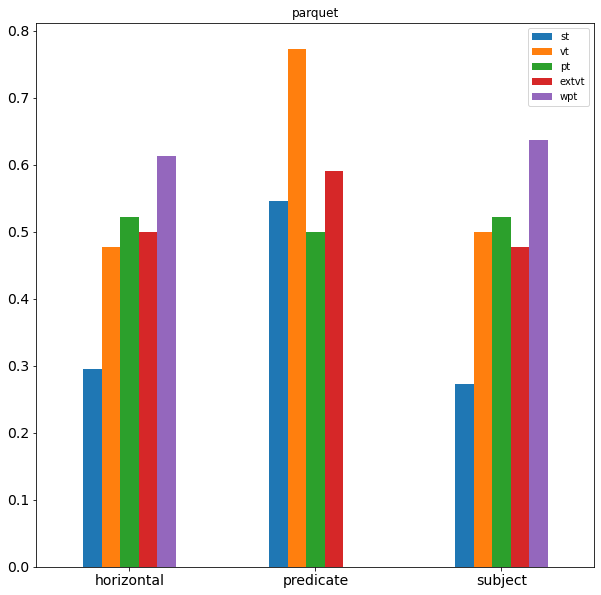

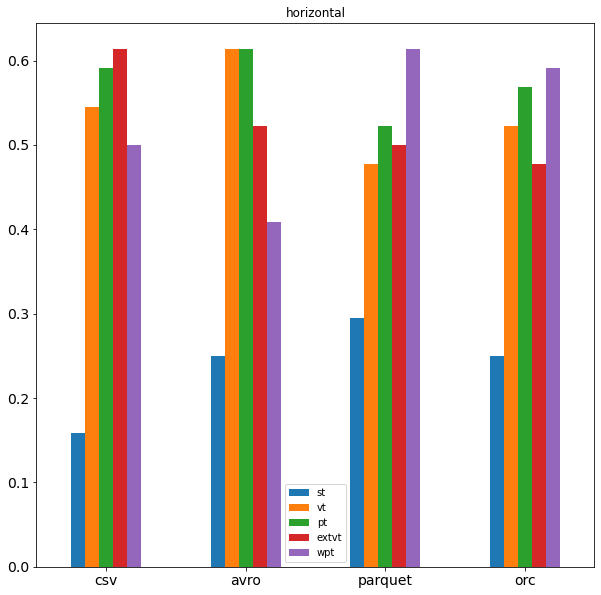

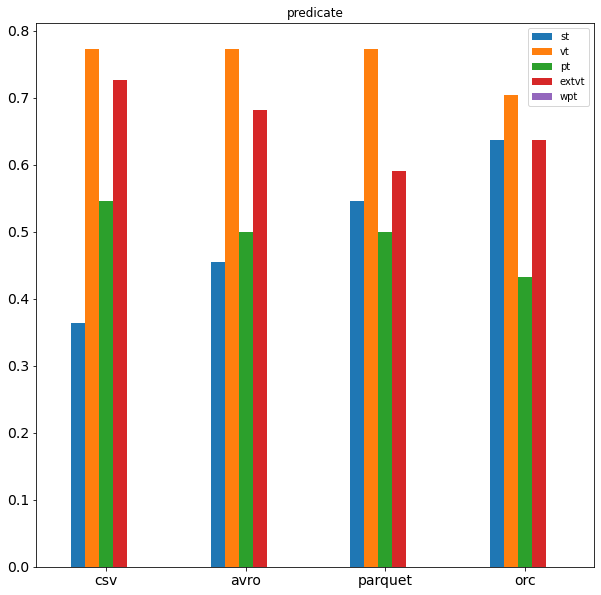

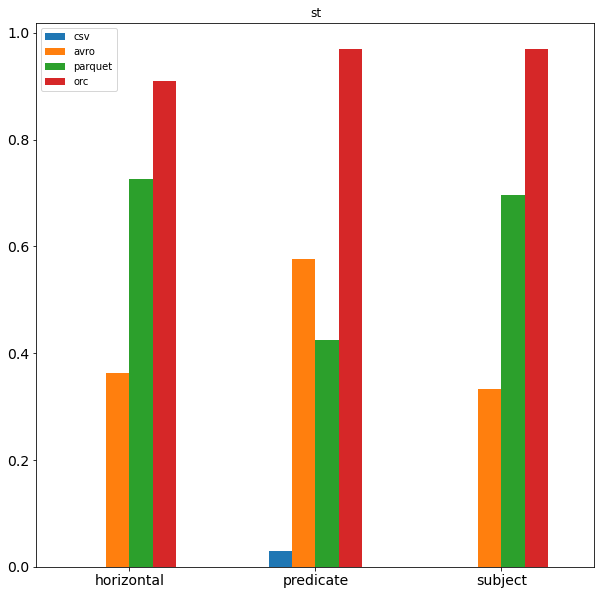

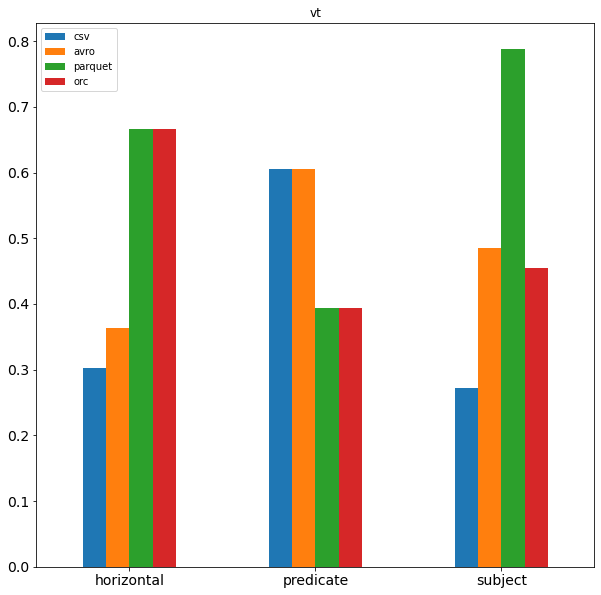

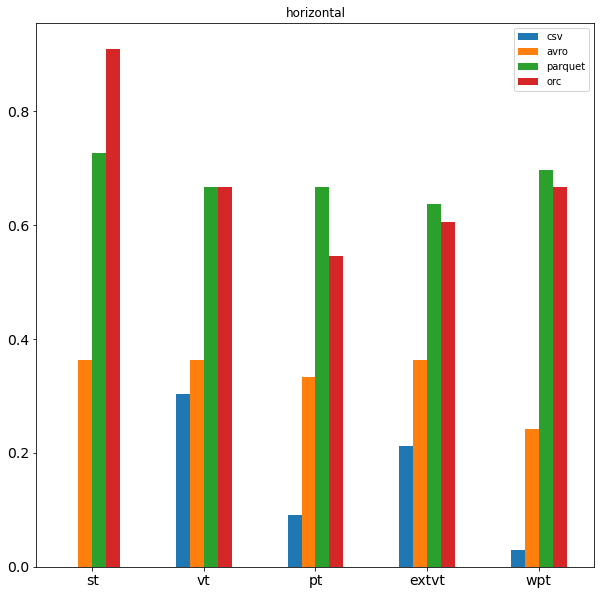

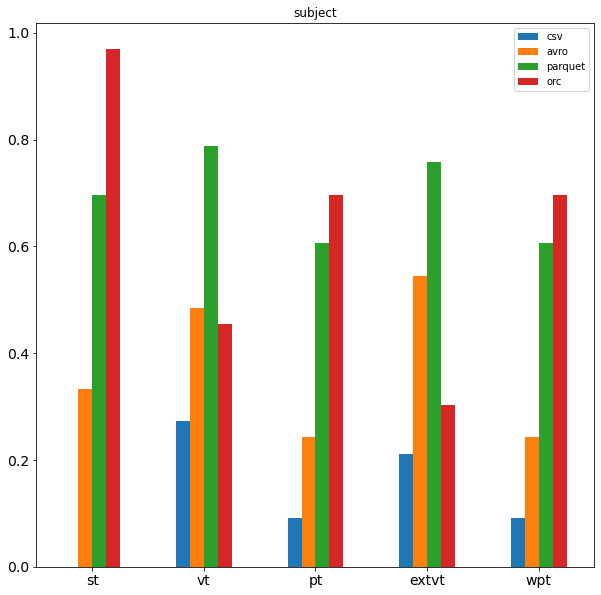

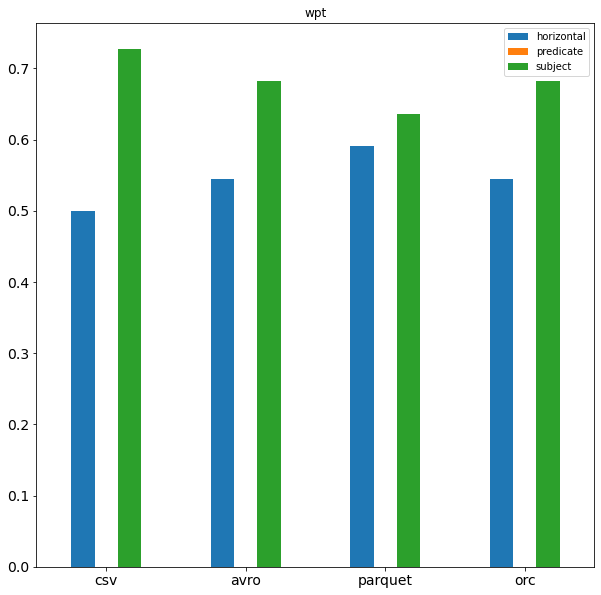

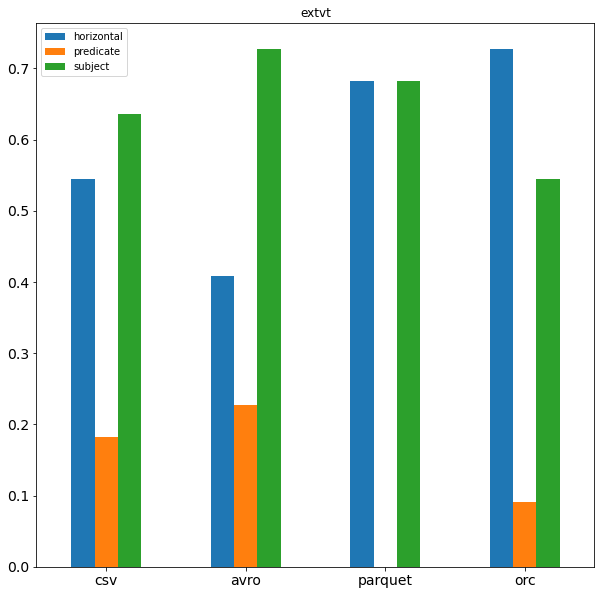

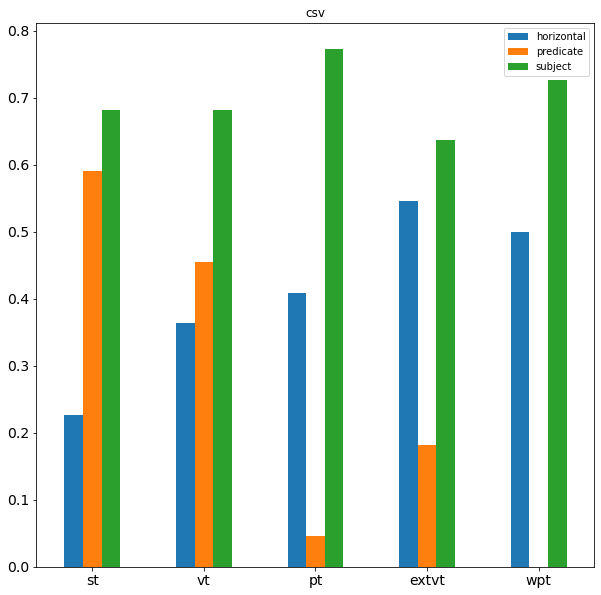

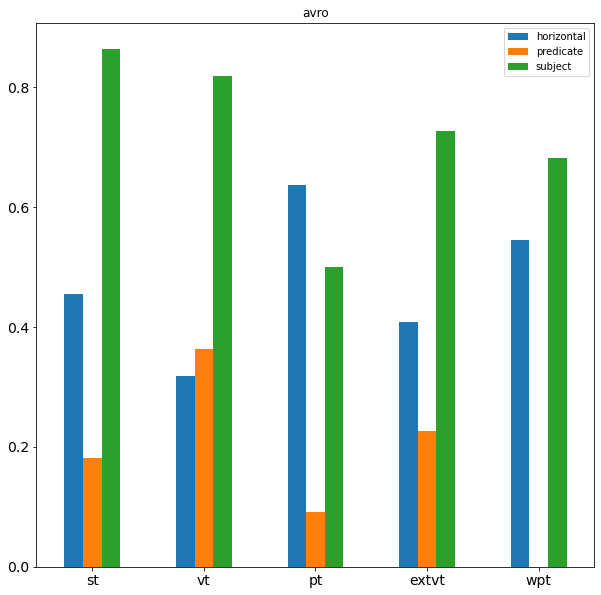

In [13]:
# example of schema dimension plots
schemaSDRank.plot('orc')
schemaSDRank.plot('parquet')
schemaSDRank.plot('horizontal')
schemaSDRank.plot('predicate')
# example of storage dimension plots
storageSDRank.plot('st')
storageSDRank.plot('vt')
storageSDRank.plot('horizontal')
storageSDRank.plot('subject')
# example of partition dimension plots
partitionSDRank.plot('wpt')
partitionSDRank.plot('extvt')
partitionSDRank.plot('csv')
partitionSDRank.plot('avro')

### Multi Dimensional Ranking

With the presence of the trade-offs introduced in the single dimensional ranking function, we propose an optimization technique that aims to find the non-dominated solutions or the configuration combinations by optimizing all dimensions at the same time which utilize the NSGA2 Algorithm.<br>
In this experiment, we provide two ways to use the NSGA2 Algorithm:
- The first method is _paretoAgg_ which operates on the single dimensional ranking criteria. This method aims to maximize performance of the three ranks altogether
- The second method is _paretoQ_ which apply the algorithm considering the rank sets obtained by sorting each query results individually. This method aims at minimizing query runtimes of the ranked dimensions

<b>MDRank</b> is the class module from PAPyA library to perform the multi dimensional optimization of NSGA2.<br>
This class takes the ranking sets of the experiments (i.e. dataset sizes) as parameter

In [14]:
# example of MDRank class with 100M dataset size as ranking set of the experiment
from PAPyA.Rank import MDRank

multiDimensionRank = MDRank(config, logs, '100M')

The output of these methods are the table of the best configurations solution of all dimensions combined sorted from the best (Solution) and the worst configurations sorted from the worst (Dominated)

In [15]:
paretoFronts_Q = multiDimensionRank.paretoQ()
paretoFronts_Agg = multiDimensionRank.paretoAgg()

In [16]:
# this is the top 5 configurations according to paretoQ method sorted from best to worst
paretoFronts_Q.head()

,Solution,Dominated
0,wpt.subject.orc,pt.horizontal.avro
1,wpt.subject.parquet,pt.subject.avro
2,vt.subject.parquet,extvt.predicate.avro
3,wpt.horizontal.orc,wpt.subject.avro
4,extvt.subject.parquet,vt.predicate.parquet


In [17]:
# this is the top 5 configurations according to paretoAgg method sorted from best to worst
paretoFronts_Agg.head()

,Solution,Dominated
0,pt.subject.csv,wpt.predicate.orc
1,extvt.predicate.avro,st.horizontal.csv
2,vt.predicate.csv,extvt.predicate.parquet
3,st.predicate.orc,pt.predicate.parquet
4,extvt.subject.avro,st.subject.csv


The <b>plot</b> method shows the solutions for _paretoAgg_ as shades of green areas projected in a three dimensional space

(9, 3) (48, 3)


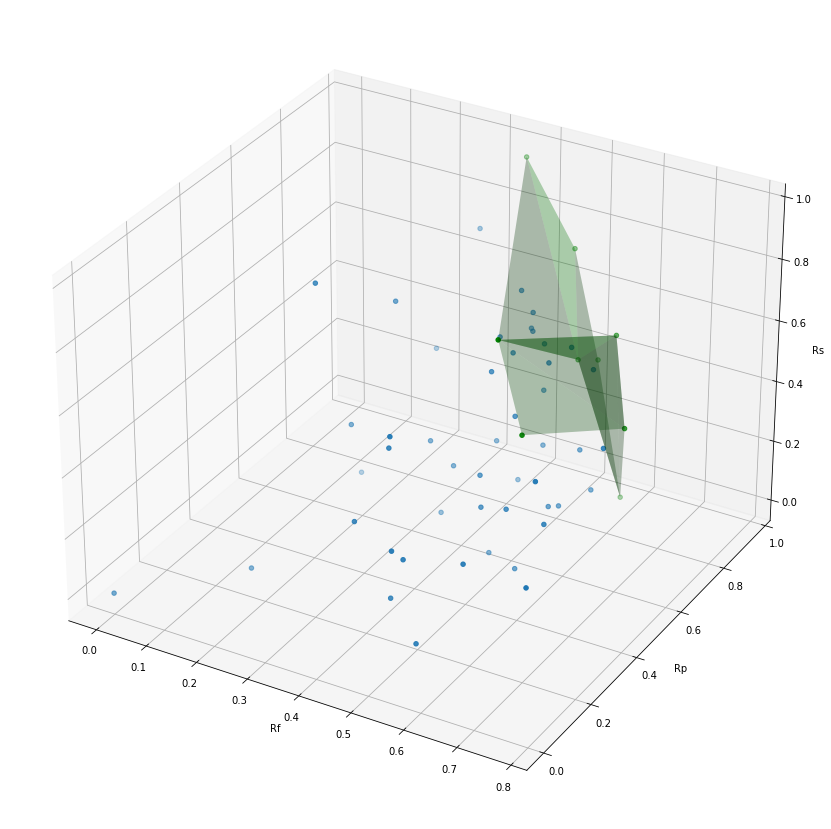

In [18]:
multiDimensionRank.plot()

<h2>Visualization</h2>
*visualization can only be done with three dimension ranking configuration

### Ranking Criteria Validation

This library provides two metrics of evaluation to evaluate the goodness of the ranking criteria the _conformance_ and _coherence_

- Conformance measures the adherence of the top-ranked configurations according to the actual query positioning of thoses configurations. We calculate conformance according to the equation below:

$$A(R^k) = 1 - \sum \limits _{i=0} ^{|Q|} \sum \limits _{j=0} ^{k} \frac {\bar{A}(i,j)}{|Q|*k}$$

Consider $R_{s}$ ranking and the top-3 ranked configurations are ${c_{1},c_{2},c_{3}}$, that overlaps only with the bottom-3 ranked configuration in query $|Q|$. That is, ${c_{4},c_{2},c_{5}}$. For example, $c_{2}$ is in the $59^{th}$ position out of 60 positions. <br>
Thus, $A(R^k) = 1- \frac {1}{(11*3)}$, when $k = 3$ and $|Q| = 11$

- Coherence is the measure agreement between two ranking sets that uses the same ranking criteria accross different experiments. We used Kendall's Index to calculate coherence, which counts the number of dis(agreements) between two ranking sets

$$K(R_{1}, R_{2}) = \sum \limits _{{i,j} \epsilon P} ^{} \frac {\bar{K}_{i,j}(R_{1}, R_{2})}{|P|}$$

In this experiment, we assume that rank sets are the dataset sizes (i.e. 100M and 250M). Kendall’s distance between two rank sets $R_{1}$ and $R_{2}$, where $|P|$ represents the set of unique pairs of distinct elements in the two sets. For instance, the $K$ index between $R_{1}={c_{1},c_{2},c_{3}}$ and $R_{2}={c_{1},c_{2},c_{4}}$ for 100M and 250M is 0.33, i.e., one disagreement out of three pair comparisons.

<b>Conformance</b> class takes a ranking set for the user to specify along with the _k_ value and _h_ value for the conformance to calculate<br>
- k_ value is the value of the top-k subset of the ranking sets
- _h_ value is the threshold value that will be counted for the conformance score

<b>Coherence</b> class counts the number of pairwise (dis)agreements between two ranking sets (i.e. dataset sizes)

In [28]:
# both conformance and coherence classes takes a list of ranking criterion that the user can specify
from PAPyA.Ranker import Conformance, Coherence

conformance_set = ['schemas', 'partition', 'storage', 'paretoQ', 'paretoAgg']
coherence_set = ['schemas', 'partition', 'storage', 'paretoQ', 'paretoAgg']

conf = Conformance(config, logs, '100M', conformance_set, 5, 28)
coh = Coherence(config, logs,coherence_set, '100M', '250M')

<b>run</b> method automates calculating the scores for _conformance_ (the higher the better) and _coherence_ (the lower the better)

In [29]:
conf.run()

,100M
schemas,0.527273
partition,0.472727
storage,0.472727
paretoQ,0.727273
paretoAgg,0.545455


In [31]:
coh.run()

,Kendall's Index
schemas,0.363842
partition,0.459887
storage,0.533333
paretoQ,0.409988
paretoAgg,0.714286


<b>showTable</b> method shows the table that we use when calculating the validation of the ranking criteria

For _conformance_, we give an example for single dimension "schemas" ranking criterion. $k=5$ gets the top 5 configuration for this ranking criterion and $h=28$ takes the rank occurences between 11 queries that has the rank > 28

In [24]:
conformance_set = ['schemas']
conf = Conformance(config, logs, '100M', conformance_set, 5, 28)
conf.showTable()

                      1   2   3   4   5   6   7   8   9   10  11
vt.predicate.avro     21  33  20  54  16  24  10  43  54  18   7
vt.predicate.csv       7  39  33  45  26  25   9  35  49  26  13
vt.predicate.parquet  16  21  28  53  31  33  12  49  52  29   8
extvt.predicate.csv    8  12  38  39  35  28  50  32  21  10  60
vt.predicate.orc      14  20  25  56  39  41  16  50  50  16  12


For _coherence_, we give an example for single dimension "partition" ranking criterion with the ranking sets of 100M and 250M which will be counted for the number of pairwise (dis)agreements in the ranking sets

In [27]:
coherence_set = ['partition']
coh = Coherence(config, logs,coherence_set, '100M', '250M')
coh.showTable()

                              100M      250M
extvt.horizontal.avro     0.409091  0.318182
extvt.horizontal.csv      0.545455  0.318182
extvt.horizontal.orc      0.727273  0.409091
extvt.horizontal.parquet  0.681818  0.363636
extvt.predicate.avro      0.227273  0.409091
extvt.predicate.csv       0.181818  0.318182
extvt.predicate.orc       0.090909  0.363636
extvt.predicate.parquet   0.000000  0.181818
extvt.subject.avro        0.727273  0.500000
extvt.subject.csv         0.636364  0.727273
extvt.subject.orc         0.545455  0.590909
extvt.subject.parquet     0.681818  0.818182
pt.horizontal.avro        0.636364  0.363636
pt.horizontal.csv         0.409091  0.454545
pt.horizontal.orc         0.454545  0.363636
pt.horizontal.parquet     0.454545  0.409091
pt.predicate.avro         0.090909  0.136364
pt.predicate.csv          0.045455  0.045455
pt.predicate.orc          0.090909  0.136364
pt.predicate.parquet      0.090909  0.136364
pt.subject.avro           0.500000  0.727273
pt.subject